<a href="https://colab.research.google.com/github/emiracless/5306/blob/main/Copy_of_ELEC_5306_Project_1_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: JPEG Compression - ELEC 5306

This file is the template for Project 1.

Please follow the instruction, code and text where it is required, and run through this file.

The original code is forked from a well-developed repo: https://github.com/ghallak/jpeg-python.

In [125]:
# get the test image for this project
!wget https://www.dropbox.com/s/hxizjdkqw2s0mth/download.png?dl=0 -O airplane.png

--2023-04-08 00:53:39--  https://www.dropbox.com/s/hxizjdkqw2s0mth/download.png?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/hxizjdkqw2s0mth/download.png [following]
--2023-04-08 00:53:39--  https://www.dropbox.com/s/raw/hxizjdkqw2s0mth/download.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbb90f44f5f9b762b4d9fa22fe6.dl.dropboxusercontent.com/cd/0/inline/B5xHSWYmEMIKfSs-4YYnPMtEbmT2hIwENqGItxIUbYDEshC8NIMCjPxBjvZnCu71rUP8yVqgC0gGzAAjg5MPe__6mllshPwrYJ_UGv2-JBh1SZUaA83N2VXg3kieh8SkR4YLCL-8wAzBHvXSKcPC2zO7mEJieNx-Cw4_lMizyYPbWg/file# [following]
--2023-04-08 00:53:40--  https://ucbb90f44f5f9b762b4d9fa22fe6.dl.dropboxusercontent.com/cd/0/inline/B5xHSWYmEMIKfSs-4YYnPMtEbmT2hIwENqGItxIUbYDEshC8NIMCjPxBjvZnCu71rUP8yVqgC0g

In [126]:
import numpy as np
from PIL import Image
i = Image.open('airplane.png')
i = np.array(i)

In [127]:
i.shape

(512, 512, 3)

In [128]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

import argparse
import os
import sys
import math
import numpy as np

from scipy import fftpack
from PIL import Image


In [129]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# This cell defines a HuffmanTree class

from queue import PriorityQueue


class HuffmanTree:

    class __Node:
        def __init__(self, value, freq, left_child, right_child):
            self.value = value
            self.freq = freq
            self.left_child = left_child
            self.right_child = right_child

        @classmethod
        def init_leaf(self, value, freq):
            return self(value, freq, None, None)

        @classmethod
        def init_node(self, left_child, right_child):
            freq = left_child.freq + right_child.freq
            return self(None, freq, left_child, right_child)

        def is_leaf(self):
            return self.value is not None

        def __eq__(self, other):
            stup = self.value, self.freq, self.left_child, self.right_child
            otup = other.value, other.freq, other.left_child, other.right_child
            return stup == otup

        def __nq__(self, other):
            return not (self == other)

        def __lt__(self, other):
            return self.freq < other.freq

        def __le__(self, other):
            return self.freq < other.freq or self.freq == other.freq

        def __gt__(self, other):
            return not (self <= other)

        def __ge__(self, other):
            return not (self < other)

    def __init__(self, arr):
        q = PriorityQueue()

        # calculate frequencies and insert them into a priority queue
        for val, freq in self.__calc_freq(arr).items():
            q.put(self.__Node.init_leaf(val, freq))

        while q.qsize() >= 2:
            u = q.get()
            v = q.get()

            q.put(self.__Node.init_node(u, v))

        self.__root = q.get()

        # dictionaries to store huffman table
        self.__value_to_bitstring = dict()

    def value_to_bitstring_table(self):
        if len(self.__value_to_bitstring.keys()) == 0:
            self.__create_huffman_table()
        return self.__value_to_bitstring

    def __create_huffman_table(self):
        def tree_traverse(current_node, bitstring=''):
            if current_node is None:
                return
            if current_node.is_leaf():
                self.__value_to_bitstring[current_node.value] = bitstring
                return
            tree_traverse(current_node.left_child, bitstring + '0')
            tree_traverse(current_node.right_child, bitstring + '1')

        tree_traverse(self.__root)

    def __calc_freq(self, arr):
        freq_dict = dict()
        for elem in arr:
            if elem in freq_dict:
                freq_dict[elem] += 1
            else:
                freq_dict[elem] = 1
        return freq_dict


In [130]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# This cell contains necessary functions for encoding

import numpy as np


def zigzag_points(rows, cols):
    # constants for directions
    UP, DOWN, RIGHT, LEFT, UP_RIGHT, DOWN_LEFT = range(6)

    # move the point in different directions
    def move(direction, point):
        return {
            UP: lambda point: (point[0] - 1, point[1]),
            DOWN: lambda point: (point[0] + 1, point[1]),
            LEFT: lambda point: (point[0], point[1] - 1),
            RIGHT: lambda point: (point[0], point[1] + 1),
            UP_RIGHT: lambda point: move(UP, move(RIGHT, point)),
            DOWN_LEFT: lambda point: move(DOWN, move(LEFT, point))
        }[direction](point)

    # return true if point is inside the block bounds
    def inbounds(point):
        return 0 <= point[0] < rows and 0 <= point[1] < cols

    # start in the top-left cell
    point = (0, 0)

    # True when moving up-right, False when moving down-left
    move_up = True

    for i in range(rows * cols):
        yield point
        if move_up:
            if inbounds(move(UP_RIGHT, point)):
                point = move(UP_RIGHT, point)
            else:
                move_up = False
                if inbounds(move(RIGHT, point)):
                    point = move(RIGHT, point)
                else:
                    point = move(DOWN, point)
        else:
            if inbounds(move(DOWN_LEFT, point)):
                point = move(DOWN_LEFT, point)
            else:
                move_up = True
                if inbounds(move(DOWN, point)):
                    point = move(DOWN, point)
                else:
                    point = move(RIGHT, point)


def bits_required(n):
    n = abs(n)
    result = 0
    while n > 0:
        n >>= 1
        result += 1
    return result


def binstr_flip(binstr):
    # check if binstr is a binary string
    if not set(binstr).issubset('01'):
        raise ValueError("binstr should have only '0's and '1's")
    return ''.join(map(lambda c: '0' if c == '1' else '1', binstr))


def uint_to_binstr(number, size):
    return bin(number)[2:][-size:].zfill(size)


def int_to_binstr(n):
    if n == 0:
        return ''

    binstr = bin(abs(n))[2:]

    # change every 0 to 1 and vice verse when n is negative
    return binstr if n > 0 else binstr_flip(binstr)


def flatten(lst):
    return [item for sublist in lst for item in sublist]
    

def block_to_zigzag(block):
    return np.array([block[point] for point in zigzag_points(*block.shape)])
    

def write_to_file(filepath, dc, ac, blocks_count, tables):
    try:
        f = open(filepath, 'w')
    except FileNotFoundError as e:
        raise FileNotFoundError(
                "No such directory: {}".format(
                    os.path.dirname(filepath))) from e

    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:

        # 16 bits for 'table_size'
        f.write(uint_to_binstr(len(tables[table_name]), 16))

        for key, value in tables[table_name].items():
            if table_name in {'dc_y', 'dc_c'}:
                # 4 bits for the 'category'
                # 4 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key, 4))
                f.write(uint_to_binstr(len(value), 4))
                f.write(value)
            else:
                # 4 bits for 'run_length'
                # 4 bits for 'size'
                # 8 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key[0], 4))
                f.write(uint_to_binstr(key[1], 4))
                f.write(uint_to_binstr(len(value), 8))
                f.write(value)

    # 32 bits for 'blocks_count'
    f.write(uint_to_binstr(blocks_count, 32))

    for b in range(blocks_count):
        for c in range(3):
            category = bits_required(dc[b, c])
            symbols, values = run_length_encode(ac[b, :, c])

            dc_table = tables['dc_y'] if c == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if c == 0 else tables['ac_c']

            f.write(dc_table[category])
            f.write(int_to_binstr(dc[b, c]))

            for i in range(len(symbols)):
                f.write(ac_table[tuple(symbols[i])])
                f.write(values[i])
    f.close()


In [58]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# This cell contains necessary functions for encoding

class JPEGFileReader:
    TABLE_SIZE_BITS = 16
    BLOCKS_COUNT_BITS = 32

    DC_CODE_LENGTH_BITS = 4
    CATEGORY_BITS = 4

    AC_CODE_LENGTH_BITS = 8
    RUN_LENGTH_BITS = 4
    SIZE_BITS = 4

    def __init__(self, filepath):
        self.__file = open(filepath, 'r')

    def read_int(self, size):
        if size == 0:
            return 0

        # the most significant bit indicates the sign of the number
        bin_num = self.__read_str(size)
        if bin_num[0] == '1':
            return self.__int2(bin_num)
        else:
            return self.__int2(binstr_flip(bin_num)) * -1

    def read_dc_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            category = self.__read_uint(self.CATEGORY_BITS)
            code_length = self.__read_uint(self.DC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = category
        return table

    def read_ac_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            run_length = self.__read_uint(self.RUN_LENGTH_BITS)
            size = self.__read_uint(self.SIZE_BITS)
            code_length = self.__read_uint(self.AC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = (run_length, size)
        return table

    def read_blocks_count(self):
        return self.__read_uint(self.BLOCKS_COUNT_BITS)

    def read_huffman_code(self, table):
        prefix = ''
        # TODO: break the loop if __read_char is not returing new char
        while prefix not in table:
            prefix += self.__read_char()
        return table[prefix]

    def __read_uint(self, size):
        if size <= 0:
            raise ValueError("size of unsigned int should be greater than 0")
        return self.__int2(self.__read_str(size))

    def __read_str(self, length):
        return self.__file.read(length)

    def __read_char(self):
        return self.__read_str(1)

    def __int2(self, bin_num):
        return int(bin_num, 2)


def read_image_file(filepath):
    reader = JPEGFileReader(filepath)

    tables = dict()
    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:
        if 'dc' in table_name:
            tables[table_name] = reader.read_dc_table()
        else:
            tables[table_name] = reader.read_ac_table()

    blocks_count = reader.read_blocks_count()

    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for block_index in range(blocks_count):
        for component in range(3):
            dc_table = tables['dc_y'] if component == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if component == 0 else tables['ac_c']

            category = reader.read_huffman_code(dc_table)
            dc[block_index, component] = reader.read_int(category)

            cells_count = 0

            # TODO: try to make reading AC coefficients better
            while cells_count < 63:
                run_length, size = reader.read_huffman_code(ac_table)

                if (run_length, size) == (0, 0):
                    while cells_count < 63:
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                else:
                    for i in range(run_length):
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                    if size == 0:
                        ac[block_index, cells_count, component] = 0
                    else:
                        value = reader.read_int(size)
                        ac[block_index, cells_count, component] = value
                    cells_count += 1

    return dc, ac, tables, blocks_count


def zigzag_to_block(zigzag):
    # assuming that the width and the height of the block are equal
    rows = cols = int(math.sqrt(len(zigzag)))

    if rows * cols != len(zigzag):
        raise ValueError("length of zigzag should be a perfect square")

    block = np.empty((rows, cols), np.int32)

    for i, point in enumerate(zigzag_points(rows, cols)):
        block[point] = zigzag[i]

    return block


def dequantize(block, component):
    q = load_quantization_table(component)
    return block * q


def idct_2d(image):
    return fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')


## Q1: 2D discrete cosine transform

**TARGET**: Re-implement the 2D DCT `fftpack.dct(x, type=2, norm='ortho)`

**REFERENCE**: Type II in https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html

**EXAMPLE**: Here is an example for re-implementing `fftpack.dct(x, type=1, norm=None)` and validation.

In [104]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# Example of a 2D DCT

def dct_2d_type_1_norm_none(image):

    def vec_cos(k, N):
        # print(k)
        # print(N-1)
        #print(np.arange(1, N-1))
        return np.cos((math.pi * k * np.arange(1, N-1)) / (N - 1))
        

    yk = np.zeros_like(image).astype(np.float32)
    for row, row_img in enumerate(image):
        vec_xn = row_img.astype(np.float32)
        vec_yk = np.zeros_like(vec_xn)
        for k in range(len(vec_yk)):
            vec_yk[k] = vec_xn[0] + (-1) ** k * vec_xn[-1] + 2 * np.sum(vec_xn[1:-1] * vec_cos(k, len(vec_xn)))
        yk[row] = vec_yk

    return yk

rnd_img = np.random.randint(0, 256, size=(4, 4))

print(fftpack.dct(rnd_img, type=1))
print(dct_2d_type_1_norm_none(rnd_img))

[[ 682.   74.  364. -118.]
 [ 554.  -78.  -58.  318.]
 [ 967. -218.  -80.    1.]
 [ 478. -206.  -98.  310.]]
[[ 682.   74.  364. -118.]
 [ 554.  -78.  -58.  318.]
 [ 967. -218.  -80.    1.]
 [ 478. -206.  -98.  310.]]


### Solution: 

Write your code below

In [81]:
rnd_img = np.random.randint(0, 256, size=(4, 4))

In [105]:
##########################
# !!!!!!!!! EDIT REQUIRED !!!!!!!!!!
##########################

# Complete this function

#also doesn't work
def dct_2d_type_2_norm_ortho(image):

  #using eqation from lecture of 2-d discrete cosine transform type-ii for f(x,y) size MxN

  m,n = np.shape(image)
  # print(m,n)
  dct_2d_matrix = np.zeros((m,n))
  # print(dct_2d_matrix)

  def cos_x(x,u,m):

    return np.cos(math.pi * ((2*x)+1) * u / (2*m))

  def cos_y(y,v,n):

    return np.cos(math.pi * ((2*y)+1) * v / (2*n))

  #ortho

  def factor_u(value,u,m):

    if u == 0:
      return value * np.sqrt(1/4*m)
    else:
      return value * np.sqrt(1/2*m)

  def factor_v(value,v,n):

    if v == 0:
      return value * np.sqrt(1/4*n)
    else:
      return value * np.sqrt(1/2*n)


  for u in range(m):
    for v in range(n):
      value=0
      for x in range(m):
        for y in range(n):
          value += image[x,y] * cos_x(x,u,m) * cos_y(y,v,n)

          #value += image[x,y] * np.dot(cos_x(x,u,m), cos_y(y,v,n))

          #factor_u
          #print("pre factor u = {}".format(value))

      value = factor_u(value,u,m)

          #factor_v
          #print("pre factor v = {}".format(value))

      value = factor_v(value,v,n)

         # print("post factor = {}".format(value))

      dct_2d_matrix[u,v] = value

      


  return dct_2d_matrix

#doesn't work when testing no ortho

def dct_1d_type_2_norm_ortho(image):

    def vec_cos(k, N):
        # print(k)
        # print(N-1)
        #print(np.arange(1, N-1))
        #print(np.arange(1, N-1) * 2 + 1)
        return np.cos((math.pi *  k * (np.arange(1, N-1)*2 + 1) / (2*N)))
        

    yk = np.zeros_like(image).astype(np.float32)
    for row, row_img in enumerate(image):
        vec_xn = row_img.astype(np.float32)
        vec_yk = np.zeros_like(vec_xn)
        for k in range(len(vec_yk)):
            #print(vec_xn)
            vec_yk[k] = 2 * np.sum(vec_xn[0:-2] * vec_cos(k, len(vec_xn)))
        yk[row] = vec_yk

    return yk


def asd2(image):

    first = dct_1d_type_2_norm_ortho(image)
    second = dct_1d_type_2_norm_ortho(np.transpose(first))
    third = np.transpose(second)

    return third

# for validation
# 1. define a image w/ random content

# 2. get result from the original function
print(fftpack.dct(rnd_img, norm='ortho'))
# 3. get result from your written function
print(dct_2d_type_2_norm_ortho(rnd_img))
# 4. compare the output and check if they're the same

[[ 288.           23.85109003  182.          -39.10403438]
 [ 175.           -0.44174256  -29.          100.84545039]
 [ 309.         -114.47947261  -40.            8.45283096]
 [ 143.          -68.75443502  -49.          103.16408128]]
[[1830.         -319.64912031  128.          346.71665649]
 [ 233.86270497  365.42344828  615.53840398 -271.75945135]
 [-106.          140.03574036  404.          -90.47646888]
 [ 507.10574363 -197.75945135  221.28821304 -395.42344828]]


In [60]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines a dct_2d function for the image, and is based on your function

# def dct_2d(image):
#   return dct_2d_type_2_norm_ortho(dct_2d_type_2_norm_ortho(image.T).T)

# if cannot figure out the dct function, uncomment below

def dct_2d(image):
 return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')

## Q2: run-length coding
**TARGET**: 
1. explain the meaning of items of `symbols` and `values` that are returned by `run_length_encode` below.
2. figure out the original array. The `symbols` of this array is:

```
[(0, 2), (0, 3), (1, 2), (0, 2), (0, 2), (2, 2), (0, 3), (0, 1), (0, 1), (1, 1), (0, 1), (0, 1), (1, 1), (0, 2), (0, 2), (0, 3), (0, 3), (0, 2), (0, 2), (0, 2), (0, 3), (0, 2), (1, 2), (0, 2), (0, 2), (0, 2)]
```
And the `values` of this array is :
```
['10', '100', '11', '10', '10', '11', '100', '1', '1', '1', '1', '1', '1', '11', '10', '100', '100', '11', '11', '10', '100', '11', '11', '11', '10', '11']
```

In [131]:
arr = np.random.randint(0, 15, size=(16,))

In [132]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines a run length encoder

def run_length_encode(arr):
    # determine where the sequence is ending prematurely
    last_nonzero = -1
    for i, elem in enumerate(arr):
        if elem != 0:
            
            last_nonzero = i
            #print(i,elem,last_nonzero)
    symbols = []

    values = []

    run_length = 0

    for i, elem in enumerate(arr):
        if i > last_nonzero:
            symbols.append((0, 0))
            values.append(int_to_binstr(0))
            #print(i,last_nonzero,symbols,values)
            break
        elif elem == 0 and run_length < 15:
            run_length += 1
        else:
            size = bits_required(elem)
            symbols.append((run_length, size))
            values.append(int_to_binstr(elem))

            #print(i,elem, symbols, values, run_length)

            run_length = 0
    return symbols, values


ss, vv = run_length_encode(arr)
print('original array: {}\n symbols: {}\n values: {}\n'.format(arr, ss, vv))

original array: [ 2 10  7  8  3  8  6  4 12  4  7 14  6  3  9 11]
 symbols: [(0, 2), (0, 4), (0, 3), (0, 4), (0, 2), (0, 4), (0, 3), (0, 3), (0, 4), (0, 3), (0, 3), (0, 4), (0, 3), (0, 2), (0, 4), (0, 4)]
 values: ['10', '1010', '111', '1000', '11', '1000', '110', '100', '1100', '100', '111', '1110', '110', '11', '1001', '1011']



### Solution:

1. Symbols is an array of tuples which represent (x,y) where x is number of zeros before the corresponding value in values. y also encodes the number of bits for the value in the original array. 

2.

In [133]:
sym = [(0, 2), (0, 3), (1, 2), (0, 2), (0, 2), (2, 2), (0, 3), (0, 1), (0, 1), (1, 1), (0, 1), (0, 1), (1, 1), (0, 2), (0, 2), (0, 3), (0, 3), (0, 2), (0, 2), (0, 2), (0, 3), (0, 2), (1, 2), (0, 2), (0, 2), (0, 2)]
val = ['10', '100', '11', '10', '10', '11', '100', '1', '1', '1', '1', '1', '1', '11', '10', '100', '100', '11', '11', '10', '100', '11', '11', '11', '10', '11']


##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines a run length encoder

def run_length_decoder(sym, val):

    arr = []

    for (i, e) in zip(enumerate(sym),sym):
      
      z = 0
      bit = 2
      
      if e[0] != 0:
        
        while z < e[0]:  
          arr.append(int(0))
          z+=1
        arr.append(int(val[i[0]], bit))

      else:         
        
        
        arr.append(int(val[i[0]], bit))
            
    return arr

print(run_length_decoder(sym,val))

[2, 4, 0, 3, 2, 2, 0, 0, 3, 4, 1, 1, 0, 1, 1, 1, 0, 1, 3, 2, 4, 4, 3, 3, 2, 4, 3, 0, 3, 3, 2, 3]


## Q3: Quantization table

**TARGET**: 
1. Explain the effect of the scalar of elements in the quantization table. (e.g. the higher, the xxx; the lower, the xxx)
2. Explain why values in the top-left corner should be lower, while those in the right-bottom corner should be higher.
3. Design a quantization table that causes no loss in information in this quantization step given the coefficients from DCT are all integers.

In [134]:

def load_quantization_table(component):
    # Quantization Table for: Photoshop - (Save For Web 080)
    # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
    if component == 'lum':
        q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 4, 5, 7, 9],
                      [2, 2, 2, 4, 5, 7, 9, 12],
                      [3, 3, 4, 5, 8, 10, 12, 12],
                      [4, 4, 5, 7, 10, 12, 12, 12],
                      [5, 5, 7, 9, 12, 12, 12, 12],
                      [6, 6, 9, 12, 12, 12, 12, 12]])
    elif component == 'chrom':
        q = np.array([[3, 3, 5, 9, 13, 15, 15, 15],
                      [3, 4, 6, 11, 14, 12, 12, 12],
                      [5, 6, 9, 14, 12, 12, 12, 12],
                      [9, 11, 14, 12, 12, 12, 12, 12],
                      [13, 14, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12]])
    else:
        raise ValueError((
            "component should be either 'lum' or 'chrom', "
            "but '{comp}' was found").format(comp=component))

    return q


def quantize(block, component):
    q = load_quantization_table(component)
    return (block / q).round().astype(np.int32)


### Solution:

1. The effect of the quantization table is to scale the DCT2 table by the corresponding amounts. The higher the number, the less of an impact as it will be divided by the number within the quantization table and rounded to the nearest integer. As a result, large numbers in the quantization model will result in a smaller contribution by the corresponding number in the DCT2 table.
2. The top left corner represents lower frequencies, while the bottom right corner represents higher frequencies. For the human eye, the impact of the lower frequencies are much more noticable and thus the respective quantization values are lower to represent more of the lower frequency data. Conversely, the bottom right of the quantization table has larger values as high frequency data is more difficult to differentiate with the human eye and thus they are not as impactful even when they are compressed and scaled down. 
3. A quantization model that has no loss in information would imply that the data is preserved and no scaling has been done. A quantization table of all 1s should represent the original DCT2 table.

In [135]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines the main function for encoding

def encode(input_file, output_file):

    image = Image.open(input_file)
    ycbcr = image.convert('YCbCr')

    npmat = np.array(ycbcr, dtype=np.uint8)

    rows, cols = npmat.shape[0], npmat.shape[1]

    # block size: 8x8
    if rows % 8 == cols % 8 == 0:
        blocks_count = rows // 8 * cols // 8
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of 8"))

    # dc is the top-left cell of the block, ac are all the other cells
    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            try:
                block_index += 1
            except NameError:
                block_index = 0

            for k in range(3):
                # split 8x8 block and center the data range on zero
                # [0, 255] --> [-128, 127]
                block = npmat[i:i+8, j:j+8, k] - 128

                dct_matrix = dct_2d(block)
                quant_matrix = quantize(dct_matrix,
                                        'lum' if k == 0 else 'chrom')
                zz = block_to_zigzag(quant_matrix)

                dc[block_index, k] = zz[0]
                ac[block_index, :, k] = zz[1:]

    H_DC_Y = HuffmanTree(np.vectorize(bits_required)(dc[:, 0]))
    H_DC_C = HuffmanTree(np.vectorize(bits_required)(dc[:, 1:].flat))
    H_AC_Y = HuffmanTree(
            flatten(run_length_encode(ac[i, :, 0])[0]
                    for i in range(blocks_count)))
    H_AC_C = HuffmanTree(
            flatten(run_length_encode(ac[i, :, j])[0]
                    for i in range(blocks_count) for j in [1, 2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}

    write_to_file(output_file, dc, ac, blocks_count, tables)


In [136]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines the main function for decoding

def decode(input_file, output_file):
    dc, ac, tables, blocks_count = read_image_file(input_file)

    # assuming that the block is a 8x8 square
    block_side = 8

    # assuming that the image height and width are equal
    image_side = int(math.sqrt(blocks_count)) * block_side

    blocks_per_line = image_side // block_side

    npmat = np.empty((image_side, image_side, 3), dtype=np.uint8)

    for block_index in range(blocks_count):
        i = block_index // blocks_per_line * block_side
        j = block_index % blocks_per_line * block_side

        for c in range(3):
            zigzag = [dc[block_index, c]] + list(ac[block_index, :, c])
            quant_matrix = zigzag_to_block(zigzag)
            dct_matrix = dequantize(quant_matrix, 'lum' if c == 0 else 'chrom')
            block = idct_2d(dct_matrix)
            npmat[i:i+8, j:j+8, c] = block + 128

    image = Image.fromarray(npmat, 'YCbCr')
    image = image.convert('RGB')
    display(image)

    image.save(output_file)

In [137]:
encode('airplane.png', 'encoded.txt')

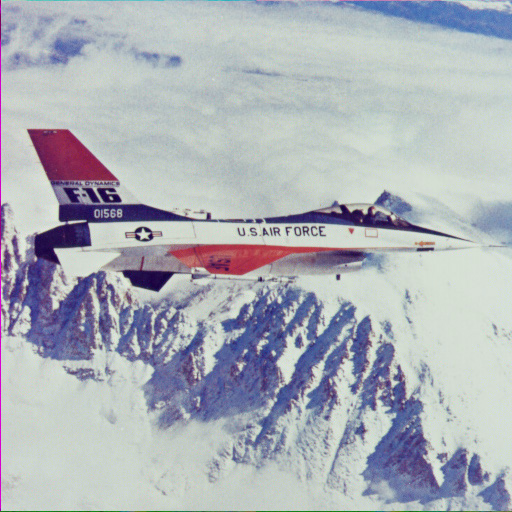

In [138]:
decode('encoded.txt', 'decoded.png')

## Q4: PSNR

**TARGET**: 
1. define a function that calculates the PSNR of a pair of images
2. calculate the PSNR of the original image and the decoded image

### Solution:

In [139]:
##########################
# !!!!!!!!! EDIT REQUIRED !!!!!!!!!!
##########################



def cal_psnr(original_image, target_image):

  mse = np.mean((original_image - target_image) ** 2)
  max_pixel = 255

  psnr=20 * np.log10(max_pixel/np.sqrt(mse))

  return psnr

original_file = 'airplane.png'
decoded_file = 'decoded.png'

img_ori = Image.open(original_file)
img_doc = Image.open(decoded_file)

img_ori = np.array(img_ori, dtype=np.float32)
img_doc = np.array(img_doc, dtype=np.float32)

print('The PSNR of the decoded image against the original one is {}'.format(cal_psnr(img_ori, img_doc)))

The PSNR of the decoded image against the original one is 34.97792981126822


## Q5 Analysis
**TARGET**:
1. define various quantization tables
2. get compressed images w/ tables defined
3. calculate the PSNR values of those images against the original one

### Solution:

In [153]:
##########################
# !!!!!!!!! EDIT REQUIRED !!!!!!!!!!
##########################



def load_new_quantization_table(component,new):
    # Quantization Table for: Photoshop - (Save For Web 080)
    # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
    if new == 1: #original

      if component == 'lum':
          q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                        [2, 2, 2, 2, 3, 4, 5, 6],
                        [2, 2, 2, 2, 4, 5, 7, 9],
                        [2, 2, 2, 4, 5, 7, 9, 12],
                        [3, 3, 4, 5, 8, 10, 12, 12],
                        [4, 4, 5, 7, 10, 12, 12, 12],
                        [5, 5, 7, 9, 12, 12, 12, 12],
                        [6, 6, 9, 12, 12, 12, 12, 12]])
      elif component == 'chrom':
          q = np.array([[3, 3, 5, 9, 13, 15, 15, 15],
                        [3, 4, 6, 11, 14, 12, 12, 12],
                        [5, 6, 9, 14, 12, 12, 12, 12],
                        [9, 11, 14, 12, 12, 12, 12, 12],
                        [13, 14, 12, 12, 12, 12, 12, 12],
                        [15, 12, 12, 12, 12, 12, 12, 12],
                        [15, 12, 12, 12, 12, 12, 12, 12],
                        [15, 12, 12, 12, 12, 12, 12, 12]])
      else:
          raise ValueError((
              "component should be either 'lum' or 'chrom', "
              "but '{comp}' was found").format(comp=component))

      return q
    
    if new == 2: #all 1

      if component == 'lum':
          q = arr = np.ones((8, 8))
      elif component == 'chrom':
          q = arr = np.ones((8, 8))
      else:
          raise ValueError((
              "component should be either 'lum' or 'chrom', "
              "but '{comp}' was found").format(comp=component))

      return q


    if new == 3: #JPEG DEFAULT

      # if component == 'lum':
      #     q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
      #                   [2, 2, 2, 2, 3, 4, 5, 6],
      #                   [2, 2, 2, 2, 4, 5, 7, 9],
      #                   [2, 2, 2, 4, 5, 7, 9, 12],
      #                   [3, 3, 4, 5, 8, 10, 12, 12],
      #                   [4, 4, 5, 7, 10, 12, 12, 12],
      #                   [5, 5, 7, 9, 12, 12, 12, 12],
      #                   [6, 6, 9, 12, 12, 12, 12, 12]])
      # elif component == 'chrom':
      #     q = np.array([[3, 3, 5, 9, 13, 15, 15, 15],
      #                   [3, 4, 6, 11, 14, 12, 12, 12],
      #                   [5, 6, 9, 14, 12, 12, 12, 12],
      #                   [9, 11, 14, 12, 12, 12, 12, 12],
      #                   [13, 14, 12, 12, 12, 12, 12, 12],
      #                   [15, 12, 12, 12, 12, 12, 12, 12],
      #                   [15, 12, 12, 12, 12, 12, 12, 12],
      #                   [15, 12, 12, 12, 12, 12, 12, 12]])
      # else:
      #     raise ValueError((
      #         "component should be either 'lum' or 'chrom', "
      #         "but '{comp}' was found").format(comp=component))      
 
      if component == 'lum':
          q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                        [12, 12, 14, 19, 26, 58, 60, 55],
                        [14, 13, 16, 24, 40, 57, 69, 56],
                        [14, 17, 22, 29, 51, 87, 80, 62],
                        [18, 22, 37, 56, 68, 109, 103, 77],
                        [24, 35, 55, 64, 81, 104, 113, 92],
                        [49, 64, 78, 87, 103, 121, 120, 101],
                        [72, 92, 95, 98, 112, 100, 103, 99]])
      elif component == 'chrom':
          q = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                        [18, 21, 26, 66, 99, 99, 99, 99],
                        [24, 26, 56, 99, 99, 99, 99, 99],
                        [47, 66, 99, 99, 99, 99, 99, 99],
                        [99, 99, 99, 99, 99, 99, 99, 99],
                        [99, 99, 99, 99, 99, 99, 99, 99],
                        [99, 99, 99, 99, 99, 99, 99, 99],
                        [99, 99, 99, 99, 99, 99, 99, 99]])
      else:
          raise ValueError((
              "component should be either 'lum' or 'chrom', "
              "but '{comp}' was found").format(comp=component))   
      return q

    if new == 4: #JPEG HIGH QUALITY
 
      if component == 'lum':
          q = np.array([[ 3,  2,  2,  3,  5,  8, 10, 12],
                        [ 2,  2,  3,  4,  5, 12, 12, 11],
                        [ 3,  3,  3,  5,  8, 11, 14, 11],
                        [ 3,  3,  4,  6, 10, 17, 16, 12],
                        [ 4,  4,  7, 11, 14, 22, 21, 15],
                        [ 5,  7, 11, 13, 16, 12, 23, 18],
                        [10, 13, 16, 17, 21, 24, 24, 21],
                        [14, 18, 19, 20, 22, 20, 20, 20]])
      elif component == 'chrom':
          q = np.array([[ 5,  5,  5,  5,  5,  5,  5,  5],
                        [ 5,  5,  5,  5,  5,  5,  5,  5],
                        [ 5,  5,  5,  5,  5,  5,  5,  5],
                        [ 5,  5,  5,  5,  5,  5,  5,  5],
                        [ 5,  5,  5,  5,  5,  5,  5,  5],
                        [ 5,  5,  5,  5,  5,  5,  5,  5],
                        [ 5,  5,  5,  5,  5,  5,  5,  5],
                        [ 5,  5,  5,  5,  5,  5,  5,  5]])
      else:
          raise ValueError((
              "component should be either 'lum' or 'chrom', "
              "but '{comp}' was found").format(comp=component))   

      return q
def new_quantize(block, component, model_type):
    # 1,2,3,4 model type
    q = load_new_quantization_table(component,model_type)
    return (block / q).round().astype(np.int32)

In [141]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines the main function for encoding

def new_encode(input_file, output_file, model_type):

    image = Image.open(input_file)
    ycbcr = image.convert('YCbCr')

    npmat = np.array(ycbcr, dtype=np.uint8)

    rows, cols = npmat.shape[0], npmat.shape[1]

    # block size: 8x8
    if rows % 8 == cols % 8 == 0:
        blocks_count = rows // 8 * cols // 8
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of 8"))

    # dc is the top-left cell of the block, ac are all the other cells
    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            try:
                block_index += 1
            except NameError:
                block_index = 0

            for k in range(3):
                # split 8x8 block and center the data range on zero
                # [0, 255] --> [-128, 127]
                block = npmat[i:i+8, j:j+8, k] - 128

                dct_matrix = dct_2d(block)
                quant_matrix = new_quantize(dct_matrix,
                                        'lum' if k == 0 else 'chrom',model_type)
                zz = block_to_zigzag(quant_matrix)

                dc[block_index, k] = zz[0]
                ac[block_index, :, k] = zz[1:]

    H_DC_Y = HuffmanTree(np.vectorize(bits_required)(dc[:, 0]))
    H_DC_C = HuffmanTree(np.vectorize(bits_required)(dc[:, 1:].flat))
    H_AC_Y = HuffmanTree(
            flatten(run_length_encode(ac[i, :, 0])[0]
                    for i in range(blocks_count)))
    H_AC_C = HuffmanTree(
            flatten(run_length_encode(ac[i, :, j])[0]
                    for i in range(blocks_count) for j in [1, 2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}
    #output_file_name = 'output_file_' + str(model_type)
    write_to_file(output_file, dc, ac, blocks_count, tables)


In [142]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines the main function for decoding

def new_decode(input_file, output_file, model_type):
    dc, ac, tables, blocks_count = read_image_file(input_file)
    #print(dc)
    # assuming that the block is a 8x8 square
    block_side = 8

    # assuming that the image height and width are equal
    image_side = int(math.sqrt(blocks_count)) * block_side

    blocks_per_line = image_side // block_side

    npmat = np.empty((image_side, image_side, 3), dtype=np.uint8)

    for block_index in range(blocks_count):
        i = block_index // blocks_per_line * block_side
        j = block_index % blocks_per_line * block_side

        for c in range(3):
            zigzag = [dc[block_index, c]] + list(ac[block_index, :, c])
            quant_matrix = zigzag_to_block(zigzag)
            dct_matrix = dequantize(quant_matrix, 'lum' if c == 0 else 'chrom')
            block = idct_2d(dct_matrix)
            npmat[i:i+8, j:j+8, c] = block + 128

    image = Image.fromarray(npmat, 'YCbCr')
    image = image.convert('RGB')
    display(image)

    #outputfilename = "output_file" + str(model_type)
    image.save(output_file)

[[284  26 416]
 [216  59 397]
 [231  98 419]
 ...
 [470 137 653]
 [646 131 629]
 [247  97 367]]


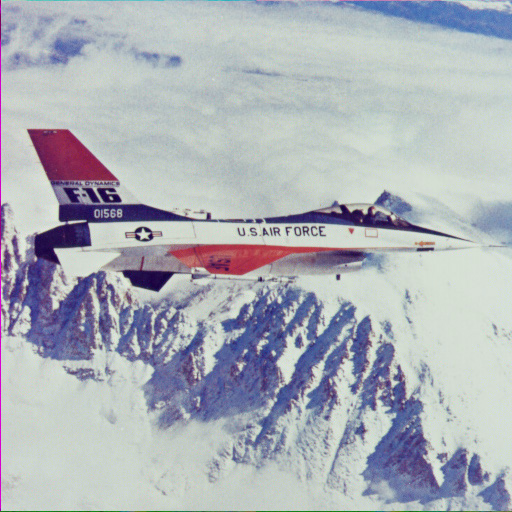

Model 1 : original
The PSNR of the decoded image against the original one is 34.97792981126822


In [143]:
new_encode('airplane.png', 'encoded_1.txt', 1)
new_decode('encoded_1.txt', 'decoded_1.png', 1)
print("Model 1 : original")

original_file = 'airplane.png'
decoded_file = 'decoded_1.png'

img_ori = Image.open(original_file)
img_doc = Image.open(decoded_file)

img_ori = np.array(img_ori, dtype=np.float32)
img_doc = np.array(img_doc, dtype=np.float32)


print('The PSNR of the decoded image against the original one is {}'.format(cal_psnr(img_ori, img_doc)))

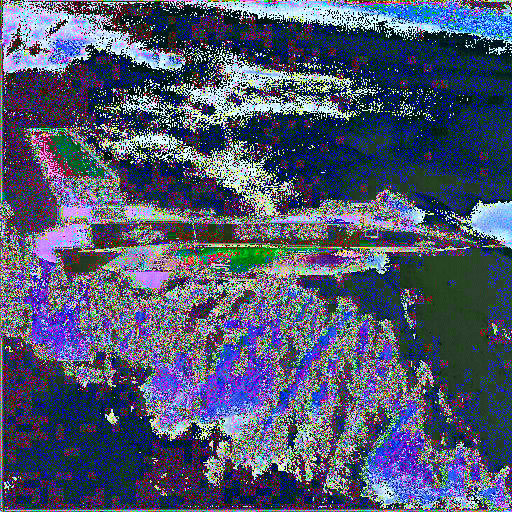

Model 2 : All 1s
The PSNR of the decoded image against the original one is 5.126522384327049


In [150]:
new_encode('airplane.png', 'encoded_2.txt', 2)
decode('encoded_2.txt', 'decoded_2.png')
print("Model 2 : All 1s")

original_file = 'airplane.png'
decoded_file = 'decoded_2.png'

img_ori = Image.open(original_file)
img_doc = Image.open(decoded_file)

img_ori = np.array(img_ori, dtype=np.float32)
img_doc = np.array(img_doc, dtype=np.float32)
print('The PSNR of the decoded image against the original one is {}'.format(cal_psnr(img_ori, img_doc)))

[[ 35   5  73]
 [ 27  10  70]
 [ 29  17  74]
 ...
 [ 59  24 115]
 [ 81  23 111]
 [ 31  17  65]]


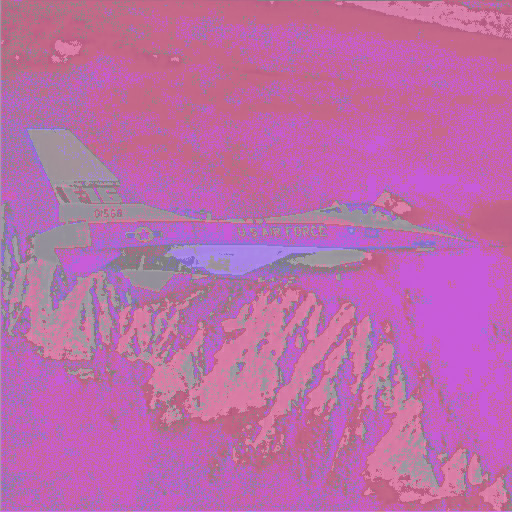

Model 3 : Default JPEG
The PSNR of the decoded image against the original one is 11.447930071241583


In [154]:
new_encode('airplane.png', 'encoded_3.txt', 3)
new_decode('encoded_3.txt', 'decoded_3.png', 3)
print("Model 3 : Default JPEG")

original_file = 'airplane.png'
decoded_file = 'decoded_3.png'

img_ori = Image.open(original_file)
img_doc = Image.open(decoded_file)

img_ori = np.array(img_ori, dtype=np.float32)
img_doc = np.array(img_doc, dtype=np.float32)

print('The PSNR of the decoded image against the original one is {}'.format(cal_psnr(img_ori, img_doc)))

[[189  16 250]
 [144  36 238]
 [154  59 251]
 ...
 [313  82 392]
 [431  78 378]
 [165  58 220]]


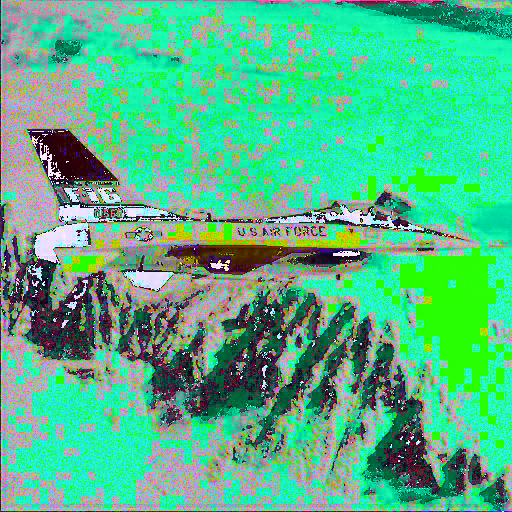

Model 4 : High Quality JPEG
The PSNR of the decoded image against the original one is 7.866642187454862


In [146]:
new_encode('airplane.png', 'encoded_4.txt', 4)
new_decode('encoded_4.txt', 'decoded_4.png', 4)
print("Model 4 : High Quality JPEG")

original_file = 'airplane.png'
decoded_file = 'decoded_4.png'

img_ori = Image.open(original_file)
img_doc = Image.open(decoded_file)

img_ori = np.array(img_ori, dtype=np.float32)
img_doc = np.array(img_doc, dtype=np.float32)

print('The PSNR of the decoded image against the original one is {}'.format(cal_psnr(img_ori, img_doc)))

Although the pictures look strange, when checking the code it does seem to be valid, as the output is the same if i replace 2,3,4 with the original tables. Perhaps there's something wrong with the decoding.


## Q6 Gray-scale
**TARGET**:
1. Convert the color image to a gray-scale one
2. perform the compression for this gray-scale image (encode, decode, visualize)

In [196]:
##########################
# !!!!!!!!! EDIT REQUIRED !!!!!!!!!!
##########################

def rgb_to_grayscale(original_image, target_image):
  original_file = 'airplane.png'
  i = Image.open(original_image)
  i = np.mean(i, axis=2)
 
  gs=Image.fromarray(i)
  gs=gs.convert("RGB") # to keep 3-D matrix for psnr comparison

  #gs.show()
  gs.save(target_image)
  
  return

rgb_to_grayscale('airplane.png','airplane_grayscale.png')

[[308   0   0]
 [226   0   0]
 [239   0   0]
 ...
 [227   0   0]
 [321   0   0]
 [255   0   0]]


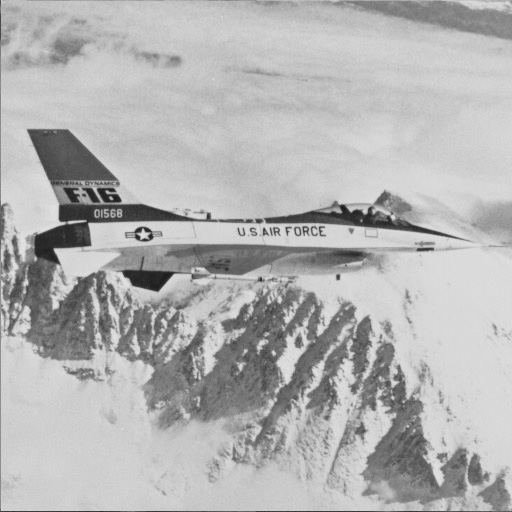

Model 1 : original
The PSNR of the decoded image against the original one is 43.649974780230416


In [197]:
new_encode('airplane_grayscale.png', 'encoded_grayscale.txt', 1)
new_decode('encoded_grayscale.txt', 'decoded_grayscale.png', 1)
print("Model 1 : original")

original_file = 'airplane_grayscale.png'
decoded_file = 'decoded_grayscale.png'

img_ori = Image.open(original_file)
img_doc = Image.open(decoded_file)

img_ori = np.array(img_ori, dtype=np.float32)
img_doc = np.array(img_doc, dtype=np.float32)


print('The PSNR of the decoded image against the original one is {}'.format(cal_psnr(img_ori, img_doc)))